In [1]:
import torch
import torch.nn as nn
from models import ISNetDIS, ISNetGTEncoder
import torch.nn.functional as F
import os
from PIL import Image
import torchvision.transforms as transforms
import time
import tqdm
import numpy as np

fea_loss = nn.MSELoss(size_average=True)
kl_loss = nn.KLDivLoss(size_average=True)
l1_loss = nn.L1Loss(size_average=True)
smooth_l1_loss = nn.SmoothL1Loss(size_average=True)
bce_loss = nn.BCELoss(size_average=True)

class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, depth_dir, gt_dir, depth_transform=None, gt_transform=None):
        self.depth_dir = depth_dir
        self.gt_dir = gt_dir
        self.depth_transform = depth_transform
        self.gt_transform = gt_transform
        self.filenames = os.listdir(depth_dir)
        # 将所有的图片提前处理并保存为 pt 文件, 保存到 cache 文件夹下
        for filename in tqdm.tqdm(self.filenames):
            # 创建 cache 文件夹
            if not os.path.exists('./cache'):
                os.mkdir('./cache')
            if not os.path.exists(os.path.join('./cache', filename.replace('.jpg', '.pt'))):
                depth = Image.open(os.path.join(self.depth_dir, filename))
                depth = depth.convert('RGB')
                if self.depth_transform:
                    depth = self.depth_transform(depth)
                torch.save(depth, os.path.join('./cache', filename.replace('.jpg', '.pt')))
            

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        depth = Image.open(os.path.join(self.depth_dir, self.filenames[idx]))
        gt = Image.open(os.path.join(self.gt_dir, self.filenames[idx].replace('.jpg', '.png')))
        depth = depth.convert('RGB')
        if self.depth_transform:
            depth = self.depth_transform(depth)
        if self.gt_transform:
            gt = self.gt_transform(gt)
        return depth, gt

def im_preprocess(im,size):
    if len(im.shape) < 3:
        im = im[:, :, np.newaxis]
    if im.shape[2] == 1:
        im = np.repeat(im, 3, axis=2)
    im_tensor = torch.tensor(im.copy(), dtype=torch.float32)
    im_tensor = torch.transpose(torch.transpose(im_tensor,1,2),0,1)
    if(len(size)<2):
        return im_tensor, im.shape[0:2]
    else:
        im_tensor = torch.unsqueeze(im_tensor,0)
        im_tensor = F.upsample(im_tensor, size, mode="bilinear")
        im_tensor = torch.squeeze(im_tensor,0)

    return im_tensor.type(torch.uint8), im.shape[0:2]

class Image_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, gt_dir, img_transform=None, gt_transform=None, name='train'):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.filenames = os.listdir(img_dir)
        self.base_cache_dir = '/root/autodl-tmp/dd-cache' + name
        # 将所有的图片提前处理并保存为 pt 文件, 保存到 cache 文件夹下
        for filename in tqdm.tqdm(self.filenames):
            # 创建 cache 文件夹
            if not os.path.exists(self.base_cache_dir):
                os.mkdir(self.base_cache_dir)
            if not os.path.exists(os.path.join(self.base_cache_dir, filename.replace('.jpg', '.pt'))):
                img = Image.open(os.path.join(self.img_dir, filename))
                img = img.convert('RGB')
                img = np.array(img)
                img, _ = im_preprocess(img, (1024, 1024))
                torch.save(img, os.path.join(self.base_cache_dir, filename.replace('.jpg', '.pt')))
                # 将图片保存为 pt 文件提高读取速度
                gt = Image.open(os.path.join(self.gt_dir, filename.replace('.jpg', '.png')))
                if self.gt_transform:
                    gt = self.gt_transform(gt)
                torch.save(gt, os.path.join(self.base_cache_dir, filename.replace('.jpg', '_gt.pt')))
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # 从 pt 文件中读取数据
        img = torch.load(os.path.join(self.base_cache_dir, self.filenames[idx].replace('.jpg', '.pt')))
        gt = torch.load(os.path.join(self.base_cache_dir, self.filenames[idx].replace('.jpg', '_gt.pt')))
        img = torch.divide(img,255.0)
        return img, gt

# 创建一个模型以 ISNetDIS 为 backbone
class DD_Net(nn.Module):
    def __init__(self, out_ch=1, pretrained=True):
        super(DD_Net, self).__init__()
        self.dis_model = ISNetDIS()
        # 冻结 backbone 的参数
        for param in self.dis_model.parameters():
            param.requires_grad = False

        self.gt_outer = ISNetGTEncoder(in_ch=6, out_ch=out_ch)

    def forward(self, x):
        # 将输出出来的 6 个特征图拼接卷积起来
        dis_res = self.dis_model(x)
        d1 = torch.cat(list(dis_res), dim=1)
        return self.gt_outer(d1)

    # 加载预训练好的骨架模型
    def load_pretrained(self, path):
        self.dis_model.load_state_dict(torch.load(path))

    # 定义损失函数
    def loss(self, pred, gt):
        return bce_loss(pred, gt)

image_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])
# 图像分割处理
gt_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])
    
net = DD_Net()
# net.load_pretrained('./isnet-general-use.pth')
# 加载预训练好的模型
net.load_state_dict(torch.load('./dd-net-ended.pth'))
net.cuda()
# 打印网路的结构与计算参数量
# print(net)
print('Total params: %.2fM' % (sum(p.numel() for p in net.parameters())/1000000.0))

# 测试输入与输出
x = torch.randn(1, 3, 1024, 1024).cuda()
y = net(x)
print(y.shape)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Total params: 50.93M


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 1, 1024, 1024])


In [3]:
# 加载数据集
train_dataset = Image_Dataset('/root/DIS/DIS5K/DIS-TR/im', '/root/DIS/DIS5K/DIS-TR/gt', image_transform, gt_transform, name='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# 验证集
val_dataset = Image_Dataset('/root/DIS/DIS5K/DIS-VD/im', '/root/DIS/DIS5K/DIS-VD/gt', image_transform, gt_transform, name='val')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# 测试集
# test_dataset = Image_Dataset('/root/DIS/DIS5K/DIS-TE1/im', '/root/DIS/DIS5K/DIS-TE1/gt', image_transform, gt_transform, name='test')
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)


# 训练
def train(net, train_loader, optimizer, epoch):
    net.train()
    average_loss = 0
    start_time = time.time()
    for i, (img, gt) in enumerate(train_loader):
        img = img.cuda()
        gt = gt.cuda()
        pred = net(img)
        loss = net.loss(pred, gt)
        average_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 打印每个训练的 loss 与当前 epoch 的进度
        print('epoch: {}, iter: {}, percent: {:.2f}%, loss: {}, cost_time: {:.6f}'.format(epoch, i, i / len(train_loader) * 100, loss.item(), time.time() - start_time))
        start_time = time.time()
    print('epoch: {}, average loss: {}'.format(epoch, average_loss / len(train_loader)))
    return average_loss / len(train_loader)

# 验证
def val(net, val_loader):
    net.eval()
    loss_sum = 0
    for j, (img, gt) in enumerate(val_loader):
        img = img.cuda()
        gt = gt.cuda()
        pred = net(img)
        loss = net.loss(pred, gt)
        loss_sum += loss.item()
    print('val loss: {}'.format(loss_sum / len(val_loader)))
    return loss_sum / len(val_loader)


# 测试
def test(net, test_loader):
    net.eval()
    loss_sum = 0
    for j, (img, gt) in enumerate(test_loader):
        img = img.cuda()
        gt = gt.cuda()
        pred = net(img)
        loss = net.loss(pred, gt)
        loss_sum += loss.item()
    print('test loss: {}'.format(loss_sum / len(test_loader)))


100%|██████████| 470/470 [00:00<00:00, 129811.86it/s]


In [ ]:
# 训练
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

epochs = 100000
current_epoch = 0

losses = []
val_losses = []

def check_early_stopping(train_loss, val_loss, patience=30):
    """
    检查早停条件，连续 patience 个 epoch 没有有效果提升时停止训练。

    参数:
        train_loss (list): 训练损失的数组。
        val_loss (list): 验证损失的数组。
        patience (int): 连续没有提升的 epoch 数量，默认为 30。

    返回:
        stop_training (bool): 是否停止训练。
    """
    if len(val_loss) < patience:
        return False  # 如果验证损失数组长度不足 patience，则继续训练
    
    best_val_loss = min(val_loss[:-patience])  # 最佳验证损失，不考虑最近 patience 个 epoch
    if min(val_loss) >= best_val_loss:
        return True  # 如果最小验证损失不再改善，则停止训练

    return False  # 其他情况继续训练


for epoch in range(current_epoch, epochs+1):
    train_loss = train(net, train_loader, optimizer, epoch)
    v_loss = val(net, val_loader)
    losses.append(train_loss)
    val_losses.append(v_loss)
    current_epoch += 1
    # 每过 30 个 epoch 保存一次模型
    if epoch % 30 == 0:
        torch.save(net.state_dict(), './dd-net-{}.pth'.format(epoch))
    if check_early_stopping(losses, val_losses):
        print("连续30 epoch 没有任何提升，退出")
        break

# test(net, test_loader)

epoch: 0, iter: 0, percent: 0.00%, loss: 0.010007757693529129, cost_time: 0.489290
epoch: 0, iter: 1, percent: 0.26%, loss: 0.0018846248276531696, cost_time: 0.487838
epoch: 0, iter: 2, percent: 0.52%, loss: 0.0019076161552220583, cost_time: 0.478934
epoch: 0, iter: 3, percent: 0.78%, loss: 0.0023636077530682087, cost_time: 0.479879
epoch: 0, iter: 4, percent: 1.03%, loss: 0.00446515716612339, cost_time: 0.487325
epoch: 0, iter: 5, percent: 1.29%, loss: 0.0019034408032894135, cost_time: 0.480382
epoch: 0, iter: 6, percent: 1.55%, loss: 0.002235607709735632, cost_time: 0.480376
epoch: 0, iter: 7, percent: 1.81%, loss: 0.0014363484224304557, cost_time: 0.488262
epoch: 0, iter: 8, percent: 2.07%, loss: 0.0014513374771922827, cost_time: 0.480314
epoch: 0, iter: 9, percent: 2.33%, loss: 0.005578852258622646, cost_time: 0.487219
epoch: 0, iter: 10, percent: 2.58%, loss: 0.0017820787616074085, cost_time: 0.477725
epoch: 0, iter: 11, percent: 2.84%, loss: 0.0021333727054297924, cost_time: 0.47

In [ ]:
# 绘制 loss 曲线
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [9]:
torch.save(net.state_dict(), './dd-net-0.pth')

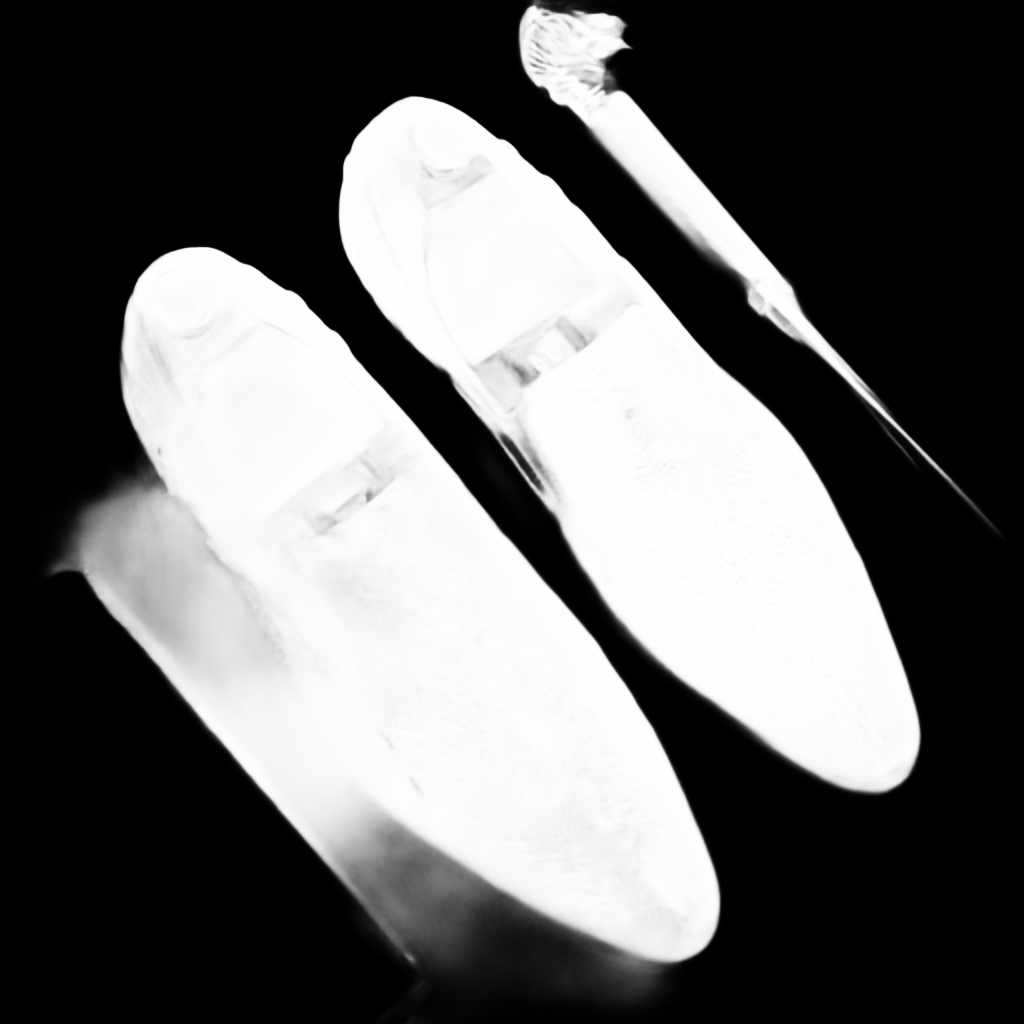

In [3]:
# 使用训练好的模型进行测试
with torch.no_grad():
    img = Image.open('./9209192613_1536303919.jpg')
    img = img.convert('RGB')
    orgin_img = img.copy()
    img = image_transform(img)
    img = img.unsqueeze(0)
    img = img.cuda()
    pred = net(img)
    pred = pred.squeeze(0)
    pred = pred.cpu().detach().numpy()
    pred = pred * 255
    pred = pred.astype('uint8')
    # 去除多余的维度
    pred = pred.squeeze(0)
    pred = Image.fromarray(pred)
    pred.show()
